# Deep Exponential Random Graph Models

### First To Do

1. Deep ERGMs
    - can I speed it up by computing df w/o calling gensim?
    - better understand implementation
        - number of epochs to use
        - number of WL iterations
        - min count?
    - confusion with IDF sampler
        - read C++ code to resolve
2. NDSSL workflow
    - try to use Byshkin C code for NDSSL
3. The KarateClub implementations have some issues:
    - not sure why they are using the previous WL hashes along with the current hashes
    - the gl2vec implementation did not implement the infer_vector function, which I basically guessed. need to check.
    
### Second To Do

1. Improve optimization
    - can I speed it up using delta f
    - can I monitor convergence? other MCMC stats?
    - can I monitor SGOF throughout training?
2. More tests
    - SGOF as a function of dim(f)
    - improve ERGM
    - other datasets
    - SGOF as a function of dim(G)
    - rescaling
    - other datasets
3. How to handle attribute data

## Set-up

In [1]:
import collections
import numpy as np
import seaborn as sns
import networkx as nx
import pandas as pd
from embeddings import *
from mcmc import *
from scipy import spatial

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

### Newman-Watts-Strogatz small-world

In [1]:
## generate some small-world graphs
Graphs = []
Ngraphs = 50
Nnodes = 150
for i in range(Ngraphs):
    Graphs.append(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=0.3, seed=i))
    

## save one of these to be the "observed" graph
np.savetxt("small_world_adj.txt", nx.adjacency_matrix(Graphs[0]).toarray(), fmt='%i',)


## display a few examples
fig = plt.figure(figsize=(16,4))

plt.subplot(141)
nx.draw(Graphs[0], node_color='k', node_size=10, with_labels=False)

plt.subplot(142)
nx.draw(Graphs[1], node_color='k', node_size=10, with_labels=False)

plt.subplot(143)
nx.draw(Graphs[2], node_color='k', node_size=10, with_labels=False)

plt.subplot(144)
nx.draw(Graphs[3], node_color='k', node_size=10, with_labels=False)

plt.show()

NameError: name 'nx' is not defined

Test the parallel MCMC - namely that it properly reverses the unaccepted moves.

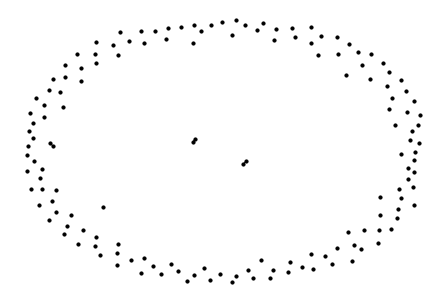

In [3]:
## I only consider independent edges, i.e. if (1,4) is considered, 
## then this is the only edge that node 1 or 4 appear in
K = 3
G = Graphs[0].copy()

## propose a move
edge_list = np.random.choice(np.arange(G.number_of_nodes()), size=2*K, replace=False)   
edge_present_list = []
for k in range(K):
    i, j = edge_list[2*k], edge_list[2*k+1] 
    edge_present_list.append(G.has_edge(i, j))

do_move_parallel(G, K, edge_list, edge_present_list)

## compare the before and after
nx.draw(nx.difference(G, Graphs[0]), node_color='k', node_size=10, with_labels=False)

In [4]:
## compare the before and after
print('Are the before/after graphs isomorhpic:', nx.is_isomorphic(Graphs[0], G))
reverse_move_parallel(G, K, edge_list, edge_present_list)
print('Does reversing the move result in the original graph:', nx.is_isomorphic(Graphs[0], G))

Are the before/after graphs isomorhpic: False
Does reversing the move result in the original graph: True


Play with the WL hashing

In [5]:
#G=nx.Graph()
#G.add_edges_from([(0,1), (0,2), (0,4), (1,4), (2,4), (3,4)])

wlit = 2

g = nx.newman_watts_strogatz_graph(n=200, k=2, p=0.3, seed=124)
#nx.draw(G)
doc0 = WeisfeilerLehmanHashing(g, wlit, False)
doc0 = doc0.get_graph_features()

i, j = np.random.choice(np.arange(g.number_of_nodes()), size=2, replace=False)         
if g.has_edge(i, j): 
    g.remove_edge(i, j)
else:
    g.add_edge(i, j)

doc1 = WeisfeilerLehmanHashing(g, wlit, False)
doc1 = doc1.get_graph_features()

In [6]:
print(len(doc0))
print(len(set(doc0)))

print(len(doc1))
print(len(set(doc1)))

print(len(set(doc1).intersection(set(doc0))))

400
150
400
150
141


## DERGM

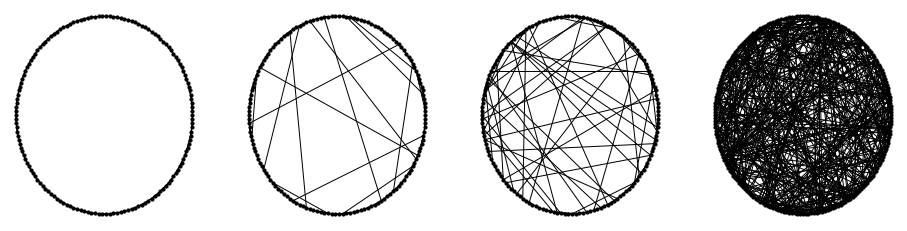

In [119]:
Graphs = []
Ngraphs = 50
Nnodes = 150
plist = np.linspace(0, 1, Nnodes)
for i in range(Ngraphs):
    Graphs.append(nx.newman_watts_strogatz_graph(n=Nnodes, k=4, p=plist[i], seed=i))
plist = np.linspace(0.01, 0.05, Nnodes)
for i in range(Ngraphs):
    Graphs.append(nx.erdos_renyi_graph(N, plist[i]))
        
## display a few examples
fig = plt.figure(figsize=(16,4))

plt.subplot(141)
nx.draw_circular(Graphs[0], node_color='k', node_size=10, with_labels=False)

plt.subplot(142)
nx.draw_circular(Graphs[10], node_color='k', node_size=10, with_labels=False)

plt.subplot(143)
nx.draw_circular(Graphs[20], node_color='k', node_size=10, with_labels=False)

plt.subplot(144)
nx.draw_circular(Graphs[-1], node_color='k', node_size=10, with_labels=False)


initialize the DERGM and train the vector embedding component

In [120]:
dim = 10
K = 1

dergm = DERGM(dim, Graph2Vec, 2, IDF_sampler, K) #GL2Vec, IDF_sampler
dergm.g2vfit(Graphs)

### Explore the embeddings

How do different outputs for the feature vectors for the same graph compare? Recall that the inference step in Graph2Vec is not deterministic.

In [ ]:
epoch_list = [2**i for i in range(1, 10)]
slist_mean = []

for epochs in epoch_list:
    Navg = 10
    vecs = np.zeros((len(Graphs), Navg, dim))
    for i in range(len(Graphs)):
        for j in range(Navg):
            vecs[i,j] = dergm.feature_func(Graphs[i], epochs=epochs)

    slist = []
    for i in range(len(Graphs)):
        for j1 in range(Navg-1):
            for j2 in range(j1+1,Navg):
                v1 = vecs[i, j1]
                v2 = vecs[i, j2]
                slist.append(spatial.distance.cosine(v1, v2))
    slist_mean.append(np.mean(slist))

    plt.hist(slist, bins=30, label=('epochs = ' + str(epochs)), density=True, histtype='step')
plt.yscale('log')
plt.legend()
plt.title('cosine distance d(f(G), f(G)), for G in training set')
plt.show()

plt.plot(epoch_list, slist_mean)
plt.xlabel('epochs')
plt.ylabel('avg. distance')
plt.show()

In [ ]:
slist_mean = []
for epochs in epoch_list:
    Navg = 10
    vecs = np.zeros((len(Graphs), Navg, dim))
    for i in range(len(Graphs)):
        for j in range(Navg):
            vecs[i,j] = dergm.feature_func(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=0.3), epochs=epochs)

    slist = []
    for i in range(len(Graphs)):
        for j1 in range(Navg-1):
            for j2 in range(j1+1,Navg):
                v1 = vecs[i, j1]
                v2 = vecs[i, j2]
                slist.append(spatial.distance.cosine(v1, v2))
    slist_mean.append(np.mean(slist))
    
    plt.hist(slist, bins=30, label=('epochs = ' + str(epochs)), density=True, histtype='step')
plt.yscale('log')
plt.legend()
plt.title('cosine distance d(f(G), f(G)), for G not in training set')
plt.show()

plt.plot(epoch_list, slist_mean)
plt.xlabel('epochs')
plt.ylabel('avg. distance')
plt.show()

How do the feature vectors for different small-world networks compare?

In [ ]:
similiarity_list = []
plist = np.linspace(0.3, 0.9, 100)
Navg_inner = 10

## loop over p-values in small-world
for p in plist:
    ## loop over dataset
    s = 0.0
    for G in Graphs:
        v0 = dergm.feature_func(Graphs[0])
        ## loop over random small-world graphs
        for i in range(Navg_inner):
            v = dergm.feature_func(nx.newman_watts_strogatz_graph(n=Nnodes, k=2, p=p, seed=i))
            s += spatial.distance.cosine(v0, v)/(Navg*len(Graphs))
    similiarity_list.append(s)

In [ ]:
plt.plot(plist, similiarity_list)
plt.xlabel('p')
plt.title('cosine distance')
plt.show()

### Explore the samplers

In [45]:
def edge_counter(G, epochs=None):
    return np.asarray(G.number_of_edges())

p = 0.02
theta_hat = np.log(p/(1-p))
N = 200
Mmax = N*(N-1)/2
Mexpected = Mmax*p
print(Mexpected)

398.0


phat =  0.021105527638190954


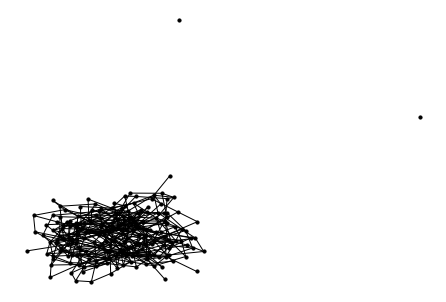

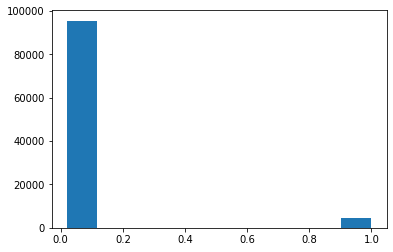

In [9]:
Gout, _, _, alpha_list = basic_sampler(nx.erdos_renyi_graph(N, 0.15), 
                                       np.asarray(theta_hat), 
                                       edge_counter,
                                       m=100000, 
                                       epochs=10)
print('phat = ', nx.density(Gout))

nx.draw(Gout, node_color='k', node_size=10, with_labels=False)
plt.show()

plt.hist(alpha_list)
plt.show()

phat =  0.08909547738693467


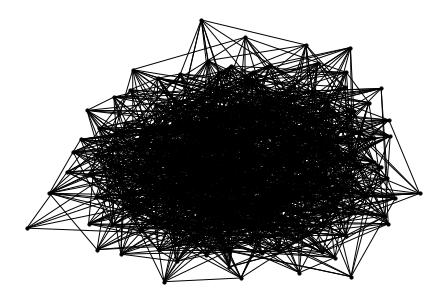

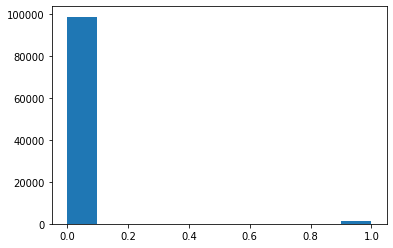

In [10]:
Gout, _, alpha_list = basic_sampler_parallel(nx.erdos_renyi_graph(N, 0.15), 
                                             np.asarray(theta_hat), 
                                             edge_counter,
                                             K = 5,
                                             m=100000, 
                                             epochs=10)
print('phat = ', nx.density(Gout))

nx.draw(Gout, node_color='k', node_size=10, with_labels=False)
plt.show()

M = Gout.number_of_edges()
p_obs = M/Mmax

plt.hist(alpha_list)
plt.show()

pinit =  0.15165829145728643
phat =  0.15165829145728643


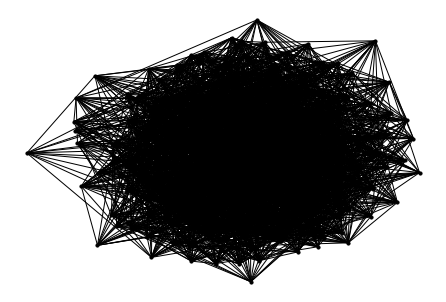

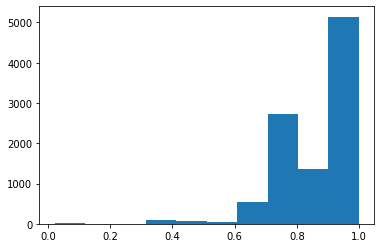

In [11]:
Ginit = nx.erdos_renyi_graph(N, 0.15)
Gout, _, _, alpha_list = IDF_sampler(Ginit, 
                                     np.asarray([theta_hat]), 
                                     edge_counter,
                                     m=10000, 
                                     epochs=10)
print('pinit = ', nx.density(Ginit))
print('phat = ', nx.density(Gout))

nx.draw(Gout, node_color='k', node_size=10, with_labels=False)
plt.show()

M = Gout.number_of_edges()
p_obs = M/Mmax

plt.hist(alpha_list)
plt.show()

# train the DERGM

initializing the EE algorithm
i_outer = 0/24
i_outer = 1/24
i_outer = 2/24
i_outer = 3/24
i_outer = 4/24
i_outer = 5/24
i_outer = 6/24
i_outer = 7/24
i_outer = 8/24
i_outer = 9/24
i_outer = 10/24
i_outer = 11/24
i_outer = 12/24
i_outer = 13/24
i_outer = 14/24
i_outer = 15/24
i_outer = 16/24
i_outer = 17/24
i_outer = 18/24
i_outer = 19/24
i_outer = 20/24
i_outer = 21/24
i_outer = 22/24
i_outer = 23/24
i_outer = 24/24


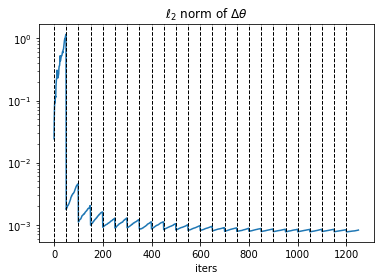

In [121]:
epochs = 16
M_outer = 25
M_inner = 50
m = 100

G_obs = nx.newman_watts_strogatz_graph(n=Nnodes, k=3, p=0.3, seed=123)
dergm.train_EE_init(basic_sampler, G_obs, M=5, m=500, epochs=epochs)
dtheta_l2_list = dergm.train_EE(G_obs, M_outer=M_outer, M_inner=M_inner, m=m, epochs=epochs, verbose=True)

ax = plt.axes()
plt.plot(dtheta_l2_list)
plt.yscale('log')
plt.title(r'$\ell_2$ norm of $\Delta \theta$')
plt.xlabel('iters')
for i in range(M_outer):
    ax.axvline(x=i*M_inner, color='k', linewidth=1, linestyle='--')
plt.show()

Simulate graphs from the trained DERGM model. Use a ER random graph as the starting point.

In [122]:
dergm.theta

array([-1.01244826e+00,  2.49320156e+00,  6.96286058e+00, -1.01338033e+01,
        4.90847977e-01, -2.68575603e+01,  1.53576231e+01,  2.74345335e+03,
       -2.73554637e-01,  4.08710173e-01])

In [123]:
np.dot(dergm.theta, dergm.feature_func(Graphs[0], epochs=epochs))

-1319.7030945047256

In [124]:
np.dot(dergm.theta, dergm.feature_func(Gstart, epochs=epochs))

-1041.7835304261537

mean acceptance ratio = 0.001


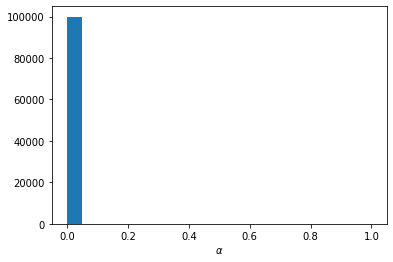

In [125]:
Nnodes = G_obs.number_of_nodes()
Nedges = G_obs.number_of_edges()
p = Nedges/(Nnodes*(Nnodes-1)/2)

Graphs_sim = []
for i in range(1):
    Gstart = nx.erdos_renyi_graph(Nnodes, p)
    G, alpha_list = dergm.sample(Gstart, m=100000, epochs=10)
    #G, _, alpha_list = basic_sampler_parallel(Gstart, dergm.theta, dergm.feature_func, 1, 1000, epochs)
    Graphs_sim.append(G)
    
print('mean acceptance ratio = %.3f' % np.mean(alpha_list))
plt.hist(alpha_list, bins=20)
plt.xlabel(r'$\alpha$')
plt.show()

load simulated graphs from a trained ERGM model (created in an R notebook)

In [126]:
nsim = 100
Graphs_sim_ergm = []
for i in range(nsim):
    Graphs_sim_ergm.append(nx.from_numpy_matrix(np.loadtxt('ergm_data/Adj_' + str(i+1) + '.txt')))

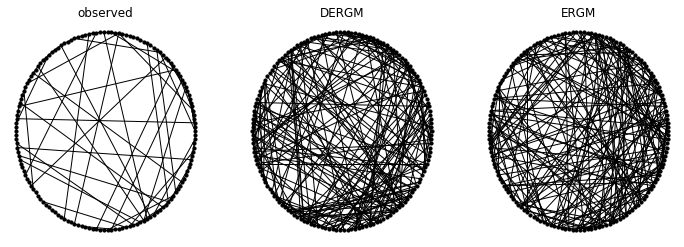

In [127]:
fig = plt.figure(figsize=(12,4))

plt.subplot(131)
plt.title('observed')
nx.draw_circular(G_obs, node_color='k', node_size=10, with_labels=False)

plt.subplot(132)
plt.title('DERGM')
nx.draw_circular(Graphs_sim[0], node_color='k', node_size=10, with_labels=False)

plt.subplot(133)
plt.title('ERGM')
nx.draw_circular(Graphs_sim_ergm[0], node_color='k', node_size=10, with_labels=False)

plt.show()

- Pick a handful of quantities of interest, such as degree, path length, etc
- Compare empirical *distributions* of these in DERGM, training data, and regular ERGM
- if possible, also show analytic result

### Spectral Goodness of Fit from [Shore, Lubin (2015)](https://arxiv.org/abs/1407.7247)

This compares graphs simulated from the model (whatever model it is, ERGM, GraphRNN, etc) to the observed graph and graphs drawn from a "null hypothesis distribution", which in this case is the ER distribution.

Spectral GOF (DERGM): 0.166
Spectral GOF (ERGM): 0.170


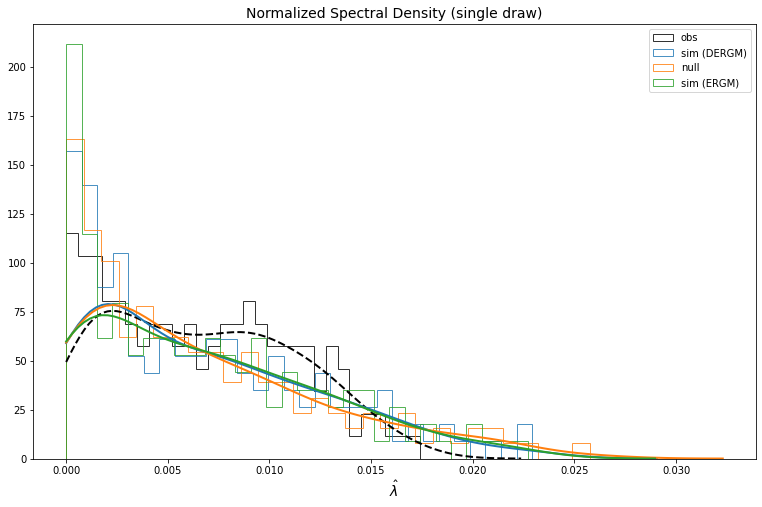

In [128]:
spectral_gof = Spectral_GOF(G_obs)
print('Spectral GOF (DERGM): %.3f' %spectral_gof.SGOF(Graphs_sim))
print('Spectral GOF (ERGM): %.3f' %spectral_gof.SGOF(Graphs_sim_ergm))

## generate 'null model' graphs, i.e. ER graphs
Graphs_null = spectral_gof.generate_null_graphs(nsim)

## compare the eigenvalue distribution for a single one of: (observed, simulated, null) graphs
nbins = 30
alpha = 0.8
golden_ratio = 1.61803398875

plt.figure(figsize=(golden_ratio*8,8))
#ax = sns.barplot(x="Word", y="Frequency", data=boxdata)

sns.distplot(spectral_gof.Laplacian_eigs(G_obs), 
             hist_kws={"alpha":alpha, "histtype":u'step'}, 
             bins=nbins, 
             label='obs', 
             kde_kws={'clip': (0.0, 1.0), "linewidth":2, "linestyle":"dashed"}, color='k')
sns.distplot(spectral_gof.Laplacian_eigs(Graphs_sim[0]), 
             hist_kws={"alpha":alpha, "histtype":u'step'}, 
             bins=nbins, 
             label='sim (DERGM)', 
             kde_kws={'clip': (0.0, 1.0), "linewidth":2})
sns.distplot(spectral_gof.Laplacian_eigs(Graphs_null[0]), 
             hist_kws={"alpha":alpha, "histtype":u'step'}, 
             bins=nbins, 
             label='null', 
             kde_kws={'clip': (0.0, 1.0), "linewidth":2})
sns.distplot(spectral_gof.Laplacian_eigs(Graphs_sim_ergm[0]), 
             hist_kws={"alpha":alpha, "histtype":u'step'}, 
             bins=nbins, 
             label='sim (ERGM)', 
             kde_kws={'clip': (0.0, 1.0), "linewidth":2})

plt.title('Normalized Spectral Density (single draw)', fontsize=14)
plt.legend()
plt.xlabel(r'$\hat{\lambda}$', fontsize=14)
plt.show()

As a check, compute the Spectral GOF using other small-world networks. This should be a larger value than the GOF of our model since now the "simulated graphs" are drawn from the same distribution as the observed graph.

In [129]:
print('Spectral GOF: %.3f' %spectral_gof.SGOF(Graphs[1:]))

ValueError: operands could not be broadcast together with shapes (99,) (1,150) 

### Degree Distribution

In [ ]:
fig, ax = plt.subplots()

degree_sequence = sorted([d for n, d in G_obs.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
#plt.bar(deg, cnt, width=0.80, color='b', label='obs')
plt.plot(deg, cnt, label='obs')

degree_sequence = sorted([d for n, d in Graphs_sim[0].degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
#plt.bar(deg, cnt, width=0.80, color='b', label='obs')
plt.plot(deg, cnt, label='sim (DERGM)')

degree_sequence = sorted([d for n, d in Graphs_null[0].degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
#plt.bar(deg, cnt, width=0.80, color='b', label='obs')
plt.plot(deg, cnt, label='null')

degree_sequence = sorted([d for n, d in Graphs_sim_ergm[0].degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
#plt.bar(deg, cnt, width=0.80, color='b', label='obs')
plt.plot(deg, cnt, label='sim (ERGM)')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.legend()
plt.show()
#ax.set_xticks([d for d in deg]);
#ax.set_xticklabels(deg)

In [132]:
import scipy
scipy.linalg.toeplitz(range(5)).astype(np.float)

array([[0., 1., 2., 3., 4.],
       [1., 0., 1., 2., 3.],
       [2., 1., 0., 1., 2.],
       [3., 2., 1., 0., 1.],
       [4., 3., 2., 1., 0.]])